In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds


/Users/leo/MasterDegree/Courses/DL/dl_env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/leo/MasterDegree/Courses/DL/dl_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
(train_data, test_data), info = tfds.load('cifar10',
                                      split=['train', 'test'],
                                      shuffle_files=True,
                                      as_supervised=True,
                                      with_info=True)


In [3]:
info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/Users/leo/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {L

In [4]:
labels_dict = dict(enumerate(info.features['label'].names))
labels_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [5]:
# train_dict = {}
# for data in train_data:
#     label = data[1].numpy()
#     train_dict[label] = train_dict.setdefault(label, 0) + 1
# print(train_dict)

In [6]:
def parse_fn(image, label):
    x = tf.cast(image, tf.float32) / 255.
    y = label
    return x, y


BATCH_SIZE = 64

AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式

train_num = int(info.splits['train'].num_examples / 10) * 9  # 訓練資料數量

train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.cache()
train_data = train_data.prefetch(tf.data.AUTOTUNE)


test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.cache()
test_data = test_data.prefetch(tf.data.AUTOTUNE)


In [8]:
L2_REG = 0
KERNEL_SIZE = 3
STRIDE_SIZE = 1

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=info.features['image'].shape),  # type: ignore
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=KERNEL_SIZE,
                           strides=STRIDE_SIZE,
                           padding='same',
                           activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=128,
                           kernel_size=KERNEL_SIZE,
                           strides=STRIDE_SIZE,
                           padding='same',
                           activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10,
                          kernel_regularizer=tf.keras.regularizers.l2(L2_REG)),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


In [9]:
import os

logdir = os.path.join(
    'logs',
    'cifar10',
    f'filter_{KERNEL_SIZE}_stride_{STRIDE_SIZE}_l2_{L2_REG}',
)
os.makedirs(logdir, exist_ok=True)

In [10]:
with open(os.path.join(logdir, 'model.json'), 'w', encoding='utf-8') as f:
    print(model.to_json(), file=f)


def log_summary(string):
    print(string)
    with open(os.path.join(logdir, 'summary.txt'), 'a', encoding='utf-8') as f:
        print(string, file=f)


model.summary(print_fn=print)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                5

In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=1,
    write_graph=True,
)

model.fit(
    train_data,
    epochs=20,
    validation_data=test_data,
    callbacks=[tensorboard_callback],
)


Epoch 1/20
782/782 [==============================] - 53s 64ms/step - loss: 1.8016 - sparse_categorical_accuracy: 0.3269 - val_loss: 1.4494 - val_sparse_categorical_accuracy: 0.4985
Epoch 2/20
782/782 [==============================] - 33s 42ms/step - loss: 1.5108 - sparse_categorical_accuracy: 0.4411 - val_loss: 1.2638 - val_sparse_categorical_accuracy: 0.5622
Epoch 3/20
782/782 [==============================] - 34s 43ms/step - loss: 1.3859 - sparse_categorical_accuracy: 0.4862 - val_loss: 1.1125 - val_sparse_categorical_accuracy: 0.6156
Epoch 4/20
782/782 [==============================] - 32s 41ms/step - loss: 1.2961 - sparse_categorical_accuracy: 0.5189 - val_loss: 1.0425 - val_sparse_categorical_accuracy: 0.6515
Epoch 5/20
782/782 [==============================] - 42s 53ms/step - loss: 1.2352 - sparse_categorical_accuracy: 0.5387 - val_loss: 1.0153 - val_sparse_categorical_accuracy: 0.6551
Epoch 6/20
782/782 [==============================] - 47s 61ms/step - loss: 1.1746 - spars

pred: 0, label: 0


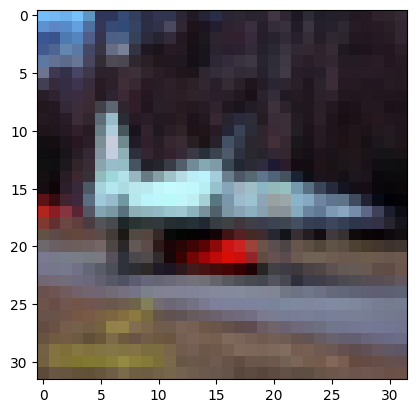

In [12]:
import matplotlib.pyplot as plt

for data, label in test_data.unbatch():
    preds = model(data[tf.newaxis, ...])[0]
    pred = tf.argmax(preds).numpy()
    label = label.numpy()

    if pred == label:
        print(f'pred: {pred}, label: {label}')
        plt.imshow(data.numpy(), cmap='gray')
        break


pred: 5, label: 7


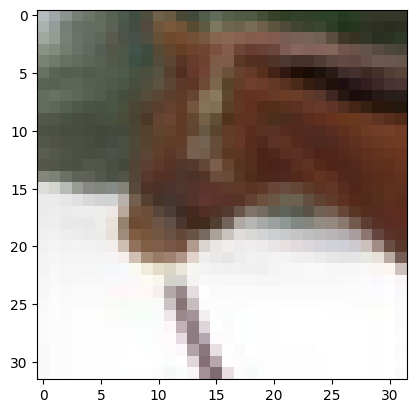

In [13]:
for data, label in test_data.unbatch():
    preds = model(data[tf.newaxis, ...])[0]
    pred = tf.argmax(preds).numpy()
    label = label.numpy()

    if pred != label:
        print(f'pred: {pred}, label: {label}')
        plt.imshow(data.numpy(), cmap='gray')
        break

5
conv2d
(1, 32, 32, 64)


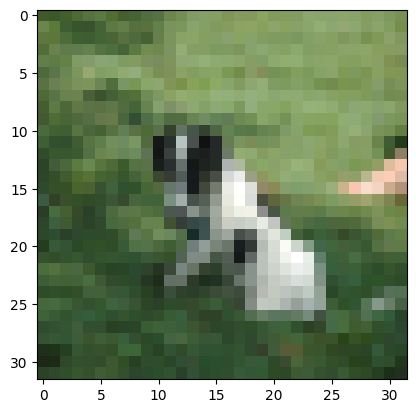

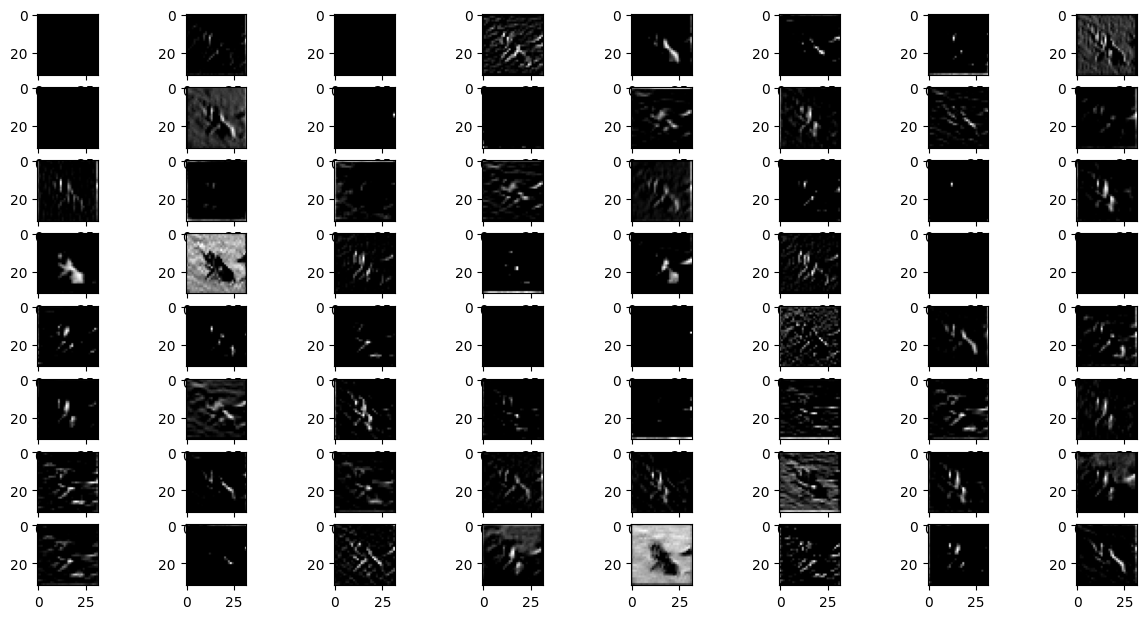

conv2d_1
(1, 16, 16, 128)


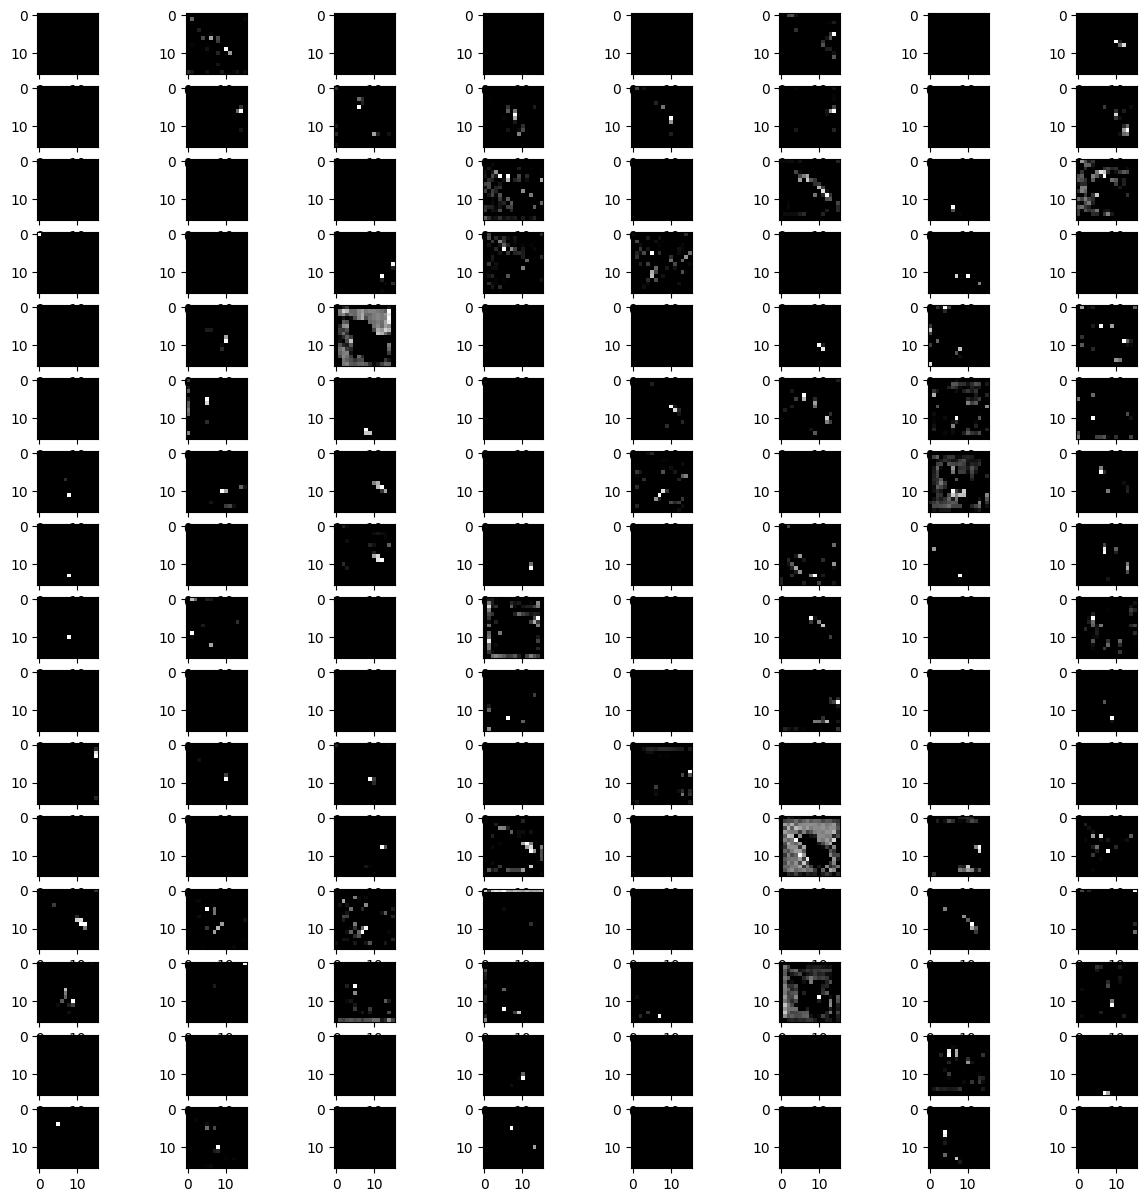

In [14]:
sample_data, sample_label = next(iter(train_data.unbatch().take(1)))
sample_data = sample_data[tf.newaxis, ...]
plt.imshow(sample_data.numpy().squeeze(), cmap='gray')
print(sample_label.numpy())

features = {}
for layer in model.layers:
    sample_data = layer(sample_data)
    if 'conv2d' in layer.name:
        features.update({layer.name: sample_data})

for name, feature in features.items():
    print(name)
    print(feature.shape)

    figure = plt.figure(figsize=(15, 15))
    for i in range(feature.shape[-1]):
        ax = figure.add_subplot(16, 8, i + 1)
        ax.imshow(feature[0, :, :, i].numpy(), cmap='gray')
    plt.show()
